In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [35]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
ls "../../DACON"

 C 드라이브의 볼륨: SSD
 볼륨 일련 번호: BCA4-98AF

 C:\Users\inhoinno\DACON 디렉터리

2020-10-08  오후 10:53    <DIR>          .
2020-10-08  오후 10:53    <DIR>          ..
2020-09-10  오후 12:55                43 .gitattributes
2020-09-25  오전 10:56    <DIR>          .ipynb_checkpoints
2020-09-27  오후 07:22       296,271,132 03pandasP.csv
2020-09-19  오후 08:17        11,060,442 EDA_train_Inhoinno(ing).ipynb
2020-10-08  오후 11:51    <DIR>          ensemble
2020-10-05  오전 12:04        82,755,465 feature.csv
2020-09-25  오전 10:59       129,839,372 feature_train_file.csv
2020-09-10  오후 12:36         2,897,812 pandasdemo.ipynb
2020-09-10  오후 12:42           800,010 sample_submission.csv
2020-09-10  오후 12:42        18,936,246 test.csv
2020-09-27  오후 09:40        55,703,747 train.csv
2020-09-27  오후 09:36       172,560,400 train_npd.csv
2020-09-10  오후 12:37    <DIR>          단국대천체모형
              10개 파일         770,824,669 바이트
               5개 디렉터리  108,245,151,744 바이트 남음


In [5]:
data_dir = Path('../../DACON')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
feature_file = data_dir / 'feature.csv'
featur_file = data_dir / 'feature0.scv'
submission = pd.read_csv("../../DACON/sample_submission.csv")

val_dir = Path('../../DACON/ensemble/build/val')
tst_dir = Path('../../DACON/ensemble/build/tst')
sub_dir = Path('../../DACON/ensemble/build/sub')

algo_name = 'lrcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
seed = 42


In [6]:
train = pd.read_csv(trn_file)
test = pd.read_csv(tst_file)
feature= pd.concat([train,test], axis =0)
feature.fillna(-1, inplace=True)
print(train.info())
print(test.info())
print(train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320000 entries, 0 to 319999
Data columns (total 20 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         320000 non-null  int64  
 1   u          320000 non-null  float64
 2   g          320000 non-null  float64
 3   r          320000 non-null  float64
 4   i          320000 non-null  float64
 5   z          320000 non-null  float64
 6   redshift   320000 non-null  float64
 7   dered_u    320000 non-null  float64
 8   dered_g    320000 non-null  float64
 9   dered_r    320000 non-null  float64
 10  dered_i    320000 non-null  float64
 11  dered_z    320000 non-null  float64
 12  nObserve   320000 non-null  int64  
 13  nDetect    320000 non-null  int64  
 14  airmass_u  320000 non-null  float64
 15  airmass_g  320000 non-null  float64
 16  airmass_r  320000 non-null  float64
 17  airmass_i  320000 non-null  float64
 18  airmass_z  320000 non-null  float64
 19  class      320000 non-n

In [7]:
feature.describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
count,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,4.0000e+05,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000
mean,199999.5000,19.8539,18.3889,17.7366,17.2007,16.9299,5.8663e-02,19.6301,18.2344,17.6162,17.1654,16.8695,6.3361,6.1426,1.1758,1.1766,1.1752,1.1755,1.1762,0.6931
std,115470.1982,1.9473,27.8367,1.4687,47.0161,52.2879,5.3757e-01,1.9231,15.9262,1.4736,22.4364,35.4365,8.8795,8.5515,0.1163,0.1181,0.1147,0.1155,0.1172,1.1827
min,0.0000,-17.6875,-17555.3656,-5.4387,-23955.8178,-23955.8178,-1.6605e+02,-42.8375,-9999.0000,-16.3802,-9999.0000,-9999.0000,1.0000,1.0000,1.0001,1.0000,1.0002,1.0001,1.0000,-1.0000
25%,99999.7500,18.7248,17.4754,16.8782,16.5241,16.2888,3.5200e-05,18.5651,17.3492,16.7879,16.4537,16.2334,1.0000,1.0000,1.0882,1.0884,1.0877,1.0880,1.0883,0.0000
50%,199999.5000,19.4208,18.1414,17.5267,17.1510,16.9184,4.7127e-02,19.2652,18.0229,17.4444,17.0881,16.8701,2.0000,2.0000,1.1793,1.1792,1.1794,1.1794,1.1793,1.0000
75%,299999.2500,20.4326,19.0745,18.4289,18.0074,17.7297,9.4629e-02,20.1981,18.8902,18.2922,17.9075,17.6560,5.0000,5.0000,1.2276,1.2260,1.2293,1.2286,1.2268,2.0000
max,399999.0000,58.6233,94.3591,72.0097,50.1641,6976.3922,6.2323e+01,30.8899,30.9529,31.9572,32.0162,30.7813,44.0000,42.0000,2.0508,2.0803,2.0221,2.0363,2.0654,2.0000


In [8]:

feature.tail()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
79995,399995,19.6734,18.6617,18.2708,18.1225,18.0627,-0.0003,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861,-1.0
79996,399996,21.5229,20.7283,20.6087,21.0049,20.8458,0.0655,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878,-1.0
79997,399997,19.3991,18.2411,18.1605,18.1978,18.2018,-0.0008,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885,-1.0
79998,399998,18.8997,17.6009,17.1329,16.8223,16.5946,0.0428,18.7715,17.4880,17.0557,16.7660,16.5585,17,17,1.1804,1.1813,1.1797,1.1800,1.1809,-1.0
79999,399999,20.7587,20.4252,20.5362,20.7729,20.9698,0.0003,20.4958,20.2181,20.3939,20.6696,20.9085,5,5,1.1832,1.1775,1.1889,1.1860,1.1803,-1.0


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         80000 non-null  int64  
 1   u          80000 non-null  float64
 2   g          80000 non-null  float64
 3   r          80000 non-null  float64
 4   i          80000 non-null  float64
 5   z          80000 non-null  float64
 6   redshift   80000 non-null  float64
 7   dered_u    80000 non-null  float64
 8   dered_g    80000 non-null  float64
 9   dered_r    80000 non-null  float64
 10  dered_i    80000 non-null  float64
 11  dered_z    80000 non-null  float64
 12  nObserve   80000 non-null  int64  
 13  nDetect    80000 non-null  int64  
 14  airmass_u  80000 non-null  float64
 15  airmass_g  80000 non-null  float64
 16  airmass_r  80000 non-null  float64
 17  airmass_i  80000 non-null  float64
 18  airmass_z  80000 non-null  float64
dtypes: float64(16), int64(3)
memory usage: 11.6 MB

In [10]:
def make_col(df):
    df['d_dered_u'] = df['dered_u'] - df['u']
    df['d_dered_g'] = df['dered_g'] - df['g']
    df['d_dered_r'] = df['dered_r'] - df['r']
    df['d_dered_i'] = df['dered_i'] - df['i']
    df['d_dered_z'] = df['dered_z'] - df['z']
    df['d_dered_rg'] = df['dered_r'] - df['dered_g']
    df['d_dered_ig'] = df['dered_i'] - df['dered_g']
    df['d_dered_zg'] = df['dered_z'] - df['dered_g']
    df['d_dered_ri'] = df['dered_r'] - df['dered_i']
    df['d_dered_rz'] = df['dered_r'] - df['dered_z']
    df['d_dered_iz'] = df['dered_i'] - df['dered_z']
    df['d_obs_det'] = df['nObserve'] - df['nDetect']

    
    # 나누기 시작
    df['n_dered_u'] = df['dered_u'] / df['u']
    df['n_dered_g'] = df['dered_g'] / df['g']
    df['n_dered_r'] = df['dered_r'] / df['r']
    df['n_dered_i'] = df['dered_i'] / df['i']
    df['n_dered_z'] = df['dered_z'] / df['z']
    df['n_dered_rg'] = df['dered_r'] / df['dered_g']
    df['n_dered_ig'] = df['dered_i'] / df['dered_g']
    df['n_dered_zg'] = df['dered_g'] / df['dered_z']
    df['n_dered_ri'] = df['dered_r'] / df['dered_i']
    df['n_dered_uz'] = df['dered_u'] / df['dered_z']
    df['n_dered_rz'] = df['dered_r'] / df['dered_z']
    df['n_dered_iz'] = df['dered_i'] / df['dered_z']
    
    # 둘이 곱하기 시작
    df['p_dered_u'] = df['d_dered_u'] * df['n_dered_u'] 
    df['p_dered_g'] = df['d_dered_g'] * df['n_dered_g']
    df['p_dered_r'] = df['d_dered_r'] * df['n_dered_r']
    df['p_dered_i'] = df['d_dered_i'] * df['n_dered_i']
    df['p_dered_z'] = df['d_dered_z'] * df['n_dered_z']
    df['d_dered_rg'] = df['d_dered_r'] * df['n_dered_g']
    df['d_dered_ig'] = df['d_dered_i'] * df['n_dered_g']
    df['d_dered_zg'] = df['d_dered_z'] * df['n_dered_g']
    df['d_dered_ri'] = df['d_dered_r'] * df['n_dered_i']
    df['d_dered_rz'] = df['d_dered_r'] * df['n_dered_z']
    df['d_dered_iz'] = df['d_dered_i'] * df['n_dered_z']
    df['d_obs_det'] = df['nObserve'] * df['nDetect']
    
    
    df.drop(['airmass_z', 'airmass_i', 'airmass_r', 'airmass_g', 'd_dered_rg', 'd_dered_ri'], axis=1, inplace=True)
    df['nObserve_log'] = df['nObserve'].apply(np.log1p)
    df['nDetect_log'] = df['nDetect'].apply(np.log1p)
    return df

In [11]:
def make_redshift(df):
    # (u  - dered_u ) / dered_u
    df['redshift_u'] = (df['u'] - df['dered_u']) / df['dered_u'] 
    df['redshift_r'] = (df['r'] - df['dered_r']) / df['dered_r'] 
    df['redshift_i'] = (df['i'] - df['dered_i']) / df['dered_i'] 
    df['redshift_g'] = (df['g'] - df['dered_g']) / df['dered_g'] 
    df['redshift_z'] = (df['z'] - df['dered_z']) / df['dered_z'] 
    return df

In [12]:
train = pd.read_csv(trn_file)
test = pd.read_csv(tst_file)
feature= pd.concat([train,test], axis =0)
feature.fillna(-1, inplace=True)
df = make_col(feature)
df = make_redshift(feature)
df_trn = make_col(train)
df_trn = make_redshift(train)

Text(0.5, 1.0, 'class vs airmass_u')

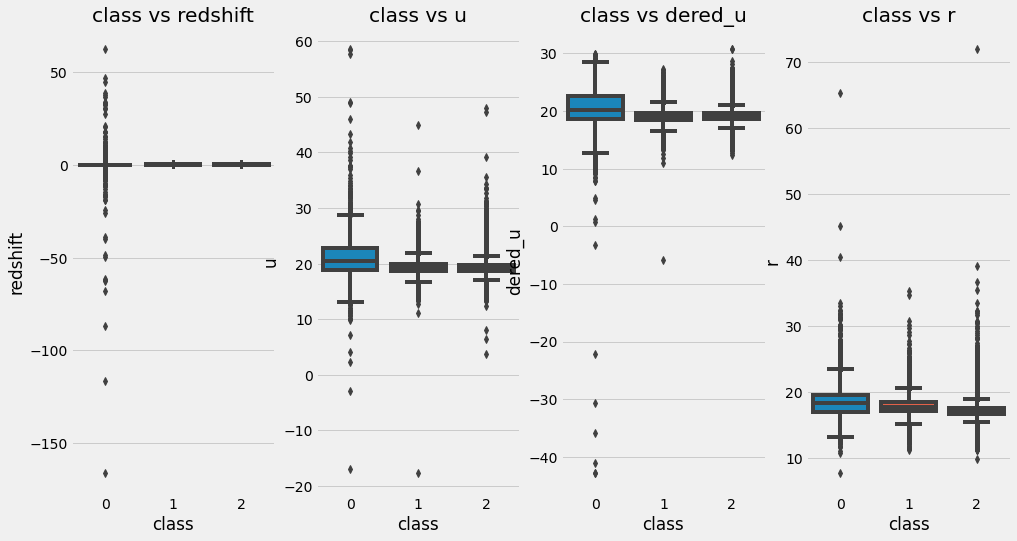

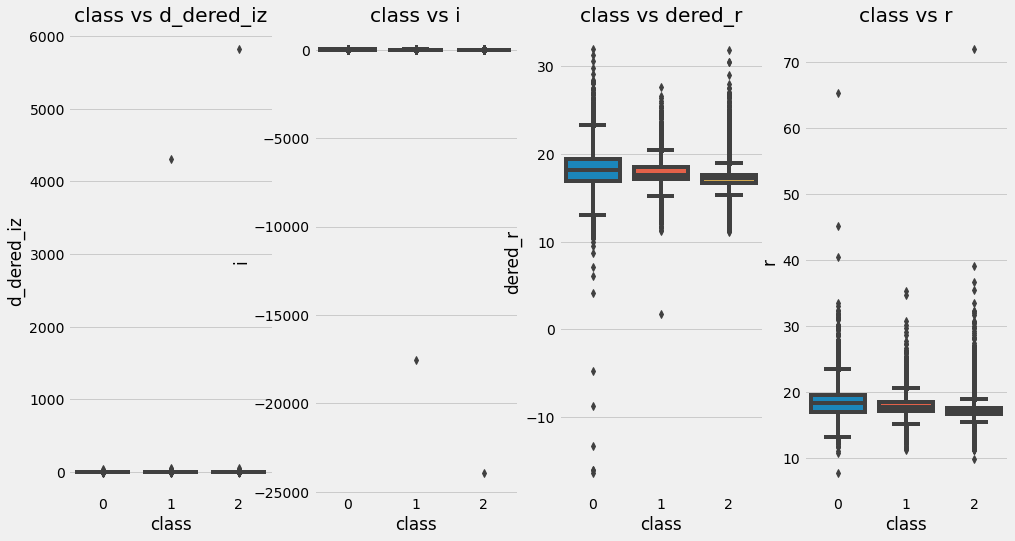

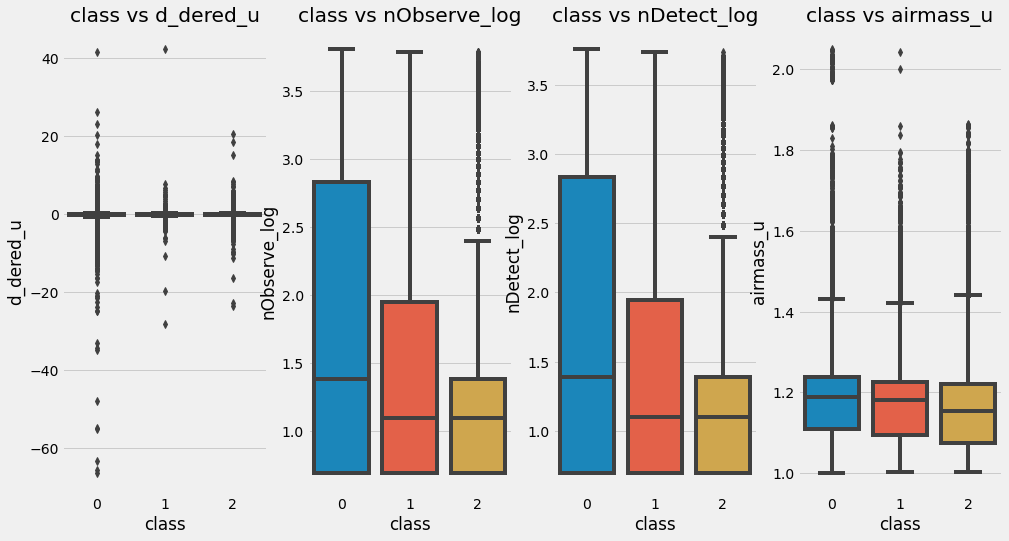

In [13]:
f , axes = plt.subplots(ncols = 4, figsize = (15,8))
data = df_trn
sns.boxplot(x = 'class', y = 'redshift', data= data, ax= axes[0])
axes[0].set_title('class vs redshift')
sns.boxplot(x = 'class', y = 'u', data= data, ax= axes[1])
axes[1].set_title('class vs u')
sns.boxplot(x = 'class', y = 'dered_u', data= data, ax= axes[2])
axes[2].set_title('class vs dered_u')
sns.boxplot(x = 'class', y = 'r', data=data, ax= axes[3])
axes[3].set_title('class vs r')

p, axes1 = plt.subplots(ncols = 4, figsize = (15,8))
sns.boxplot(x = 'class', y = 'd_dered_iz', data=data, ax= axes1[0])
axes1[0].set_title('class vs d_dered_iz')
sns.boxplot(x = 'class', y = 'i', data=data, ax= axes1[1])
axes1[1].set_title('class vs i')
sns.boxplot(x = 'class', y = 'dered_r', data= data, ax= axes1[2])
axes1[2].set_title('class vs dered_r')
sns.boxplot(x = 'class', y = 'r', data=data, ax= axes1[3])
axes1[3].set_title('class vs r')

k, axes2 = plt.subplots(ncols = 4, figsize = (15,8))
sns.boxplot(x = 'class', y = 'd_dered_u', data= data, ax= axes2[0])
axes2[0].set_title('class vs d_dered_u')
sns.boxplot(x = 'class', y = 'nObserve_log', data=data, ax= axes2[1])
axes2[1].set_title('class vs nObserve_log')
sns.boxplot(x = 'class', y = 'nDetect_log', data=data, ax= axes2[2])
axes2[2].set_title('class vs nDetect_log')
sns.boxplot(x = 'class', y = 'airmass_u', data= data, ax= axes2[3])
axes2[3].set_title('class vs airmass_u')


In [14]:
target_col = 'class'
pred_col = 'pred'
num_cols = [x for x in train.columns if train[x].dtype in [np.int64, np.float64] and x != target_col]
print(num_cols)

['id', 'u', 'g', 'r', 'i', 'z', 'redshift', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'nObserve', 'nDetect', 'airmass_u', 'd_dered_u', 'd_dered_g', 'd_dered_r', 'd_dered_i', 'd_dered_z', 'd_dered_ig', 'd_dered_zg', 'd_dered_rz', 'd_dered_iz', 'd_obs_det', 'n_dered_u', 'n_dered_g', 'n_dered_r', 'n_dered_i', 'n_dered_z', 'n_dered_rg', 'n_dered_ig', 'n_dered_zg', 'n_dered_ri', 'n_dered_uz', 'n_dered_rz', 'n_dered_iz', 'p_dered_u', 'p_dered_g', 'p_dered_r', 'p_dered_i', 'p_dered_z', 'nObserve_log', 'nDetect_log', 'redshift_u', 'redshift_r', 'redshift_i', 'redshift_g', 'redshift_z']


In [15]:
cols_to_use = ['redshift', 
               'd_dered_u', 'd_dered_g', 'd_dered_r', 'd_dered_i', 'd_dered_z', 'd_dered_zg', 'd_dered_rz', 'd_dered_iz', 
               'n_dered_u', 'n_dered_g', 'n_dered_r', 'n_dered_i', 'n_dered_z','n_dered_uz','n_dered_zg','n_dered_rg','n_dered_ri','n_dered_rz','n_dered_iz',
               'nObserve_log', 'nDetect_log']
#이 중 정규화를 했으면 좋겠는 열은 g, z, dered_z
#이외로 train에서는 i,dered_g, dered_i에서 Outlier가 있고
# test 에서는 g,z,dered_z
# Redshift의 경우 제일 영향이 많은 Column이므로 섣부른 정규화는 조심히 수행하자
cols_to_scale = ['g','z','dered_z']
cols_to_use

['redshift',
 'd_dered_u',
 'd_dered_g',
 'd_dered_r',
 'd_dered_i',
 'd_dered_z',
 'd_dered_zg',
 'd_dered_rz',
 'd_dered_iz',
 'n_dered_u',
 'n_dered_g',
 'n_dered_r',
 'n_dered_i',
 'n_dered_z',
 'n_dered_uz',
 'n_dered_zg',
 'n_dered_rg',
 'n_dered_ri',
 'n_dered_rz',
 'n_dered_iz',
 'nObserve_log',
 'nDetect_log']

In [16]:
cols_to_use_best = ['redshift',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'airmass_u',
 'd_dered_ig',
 'd_dered_zg',
 'd_dered_rz',
 'd_dered_iz',

 'n_dered_u',
 'n_dered_g',
 'n_dered_r',
 'n_dered_i',
 'n_dered_z',
 'n_dered_rg',
 'n_dered_ig',
 'n_dered_zg',
 'n_dered_ri',
 'n_dered_rz',
 #'n_dered_iz',#?
 
 'nObserve_log',
 'nDetect_log'] #93.40

In [17]:
cols_clean = ['u', 'g', 'r', 'i', 'z', 'redshift', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z','nObserve_log', 'nDetect_log']
d_cols = [ 'redshift','d_dered_u', 'd_dered_g', 'd_dered_r', 'd_dered_i', 'd_dered_z', 'd_dered_zg', 'd_dered_rz', 'd_dered_iz',]
d_cols_m = [ 'redshift','d_dered_ig','d_dered_zg','d_dered_rz','d_dered_iz']
n_cols = ['redshift','n_dered_u', 'n_dered_g', 'n_dered_r', 'n_dered_i', 'n_dered_z']
n_cols_m = ['redshift','n_dered_rg','n_dered_ig','n_dered_zg','n_dered_ri','n_dered_rz','n_dered_iz']
p_cols = ['redshift','p_dered_u', 'p_dered_g', 'p_dered_r', 'p_dered_i', 'p_dered_z'] 
p_cols_m = ['redshift', 'p_dered_rg', 'p_dered_ru', 'p_dered_ig', 'p_dered_zg', 'p_dered_ri', 'p_dered_rz', 'p_dered_iz']

In [18]:
cols_proba = list()

In [19]:
df_trn[cols_clean+['class']].corr().style.background_gradient()
#상관관계가 높을 수록 진하게 나타낸다
# > 'g','i','z','redshift','dered_g', 'dered_i', 'dered_z'
cols_proba.append(['g','i','z','redshift','dered_g', 'dered_i', 'dered_z'])

In [20]:
df_trn[d_cols + ['class']].corr().style.background_gradient()
# 'd_dered_u','d_dered_r' , 'd_dered_i', 'd_dered_z' , 'd_dered_zg' , 'd_dered_rz', 'd_dered_iz'
cols_proba.append(['d_dered_u','d_dered_r' , 'd_dered_i', 'd_dered_z' , 'd_dered_zg' , 'd_dered_rz', 'd_dered_iz'])

In [21]:
df_trn[d_cols_m + ['class']].corr().style.background_gradient()
# > 'd_dered_ig' ,'d_dered_zg', 'd_dered_rz', 'd_dered_iz'
cols_proba.append(['d_dered_ig' ,'d_dered_zg', 'd_dered_rz', 'd_dered_iz'])

In [22]:
df_trn[n_cols + ['class']].corr().style.background_gradient()
# > 'n_dered_u' , 'n_dered_r', 'n_dered_g', 'n_dered_i'
#plt.figure(figsize=(15,15))
#sns.heatmap(data = df_trn[n_cols + ['class']].corr(), annot=True, 
#fmt = '.2f', linewidths=.5, cmap='Blues')
cols_proba.append(['n_dered_u' , 'n_dered_r', 'n_dered_g', 'n_dered_i'])

In [23]:
df_trn[n_cols_m + ['class']].corr().style.background_gradient()
#> ''n_dered_rg' 'n_dered_ri' 'n_dered_iz','n_dered_rz' 
#plt.figure(figsize=(15,15))
#sns.heatmap(data = df_trn[n_cols_m + ['class']].corr(), annot=True, 
#fmt = '.2f', linewidths=.5, cmap='Blues')
cols_proba.append(['n_dered_rg' 'n_dered_ri' 'n_dered_iz','n_dered_rz'])

In [24]:
df_trn[p_cols + ['class']].corr().style.background_gradient()
# > 'p_dered_r'
#plt.figure(figsize=(15,15))
# 'p_dered_u', 'p_dered_r'
#sns.heatmap(data = df_trn[p_cols + ['class']].corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
cols_proba.append(['p_dered_u', 'p_dered_r'])

In [25]:
df[cols_to_use_best + ['class']].corr().style.background_gradient()
#상관관계가 높을 수록 진하게 나타낸다

,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,n_dered_u,n_dered_g,n_dered_r,n_dered_i,n_dered_z,n_dered_rg,n_dered_ig,n_dered_zg,n_dered_ri,n_dered_rz,nObserve_log,nDetect_log,class
redshift,1.0000,-0.0080,-0.0002,-0.0028,-0.0001,-0.0001,0.0011,0.0001,0.0001,0.0028,0.0002,0.0007,0.0053,0.0084,0.0060,0.0003,-0.0062,-0.0001,-0.0007,-0.0019,-0.0031,-0.0092,-0.0089,0.0484
dered_u,-0.0080,1.0000,0.0969,0.8392,0.0423,0.0249,0.0889,-0.0002,0.0030,0.0282,0.0017,0.0461,0.1061,0.1439,0.1222,0.0448,-0.3148,-0.0269,0.2312,0.1638,0.2680,0.2337,0.2265,-0.2120
dered_g,-0.0002,0.0969,1.0000,0.0990,0.7072,0.4476,0.0071,-0.2953,-0.1914,0.0023,-0.5904,0.0053,0.0255,0.0150,0.0420,0.0169,0.0145,-0.0025,0.0216,0.0298,0.0409,0.0222,0.0215,-0.0219
dered_r,-0.0028,0.8392,0.0990,1.0000,0.0549,0.0340,0.0848,0.0007,0.0043,0.0213,0.0025,0.0453,0.1016,0.1385,0.1220,0.0330,-0.0387,-0.0121,0.1299,0.1224,0.1932,0.2100,0.1994,-0.2139
dered_i,-0.0001,0.0423,0.7072,0.0549,1.0000,0.6331,0.0026,-0.8835,-0.5736,0.0013,-0.9864,0.0026,0.0157,0.0082,0.0561,0.0238,0.0308,0.7044,0.0090,0.0221,0.0266,0.0118,0.0116,-0.0136
dered_z,-0.0001,0.0249,0.4476,0.0340,0.6331,1.0000,-0.0010,-0.5594,0.0175,0.0006,-0.6246,0.0015,0.0094,0.0042,0.0346,0.0442,0.0218,0.4461,0.0140,0.0131,0.0341,0.0075,0.0075,-0.0090
airmass_u,0.0011,0.0889,0.0071,0.0848,0.0026,-0.0010,1.0000,0.0024,-0.0011,0.0073,0.0031,0.0112,0.0200,0.0299,0.0258,0.0077,-0.0186,-0.0030,0.0071,0.0039,0.0064,0.2507,0.2491,-0.0483
d_dered_ig,0.0001,-0.0002,-0.2953,0.0007,-0.8835,-0.5594,0.0024,1.0000,0.6494,0.0028,0.9442,0.0010,0.0011,0.0042,-0.0417,-0.0180,-0.0120,-0.9527,-0.0087,-0.0187,-0.0205,0.0003,-0.0001,0.0026
d_dered_zg,0.0001,0.0030,-0.1914,0.0043,-0.5736,0.0175,-0.0011,0.6494,1.0000,0.0137,0.6132,0.0010,0.0073,0.0032,-0.0283,0.0527,-0.0073,-0.6188,0.0014,-0.0121,0.0003,0.0013,0.0011,0.0031
d_dered_rz,0.0028,0.0282,0.0023,0.0213,0.0013,0.0006,0.0073,0.0028,0.0137,1.0000,0.0080,0.0439,0.5442,0.4073,0.1230,0.8228,-0.0068,-0.0003,0.0065,0.0079,0.0056,-0.0071,-0.0069,0.0232


In [26]:
cols_redshift = ['redshift','redshift_u', 'redshift_r', 'redshift_i', 'redshift_g', 'redshift_z']

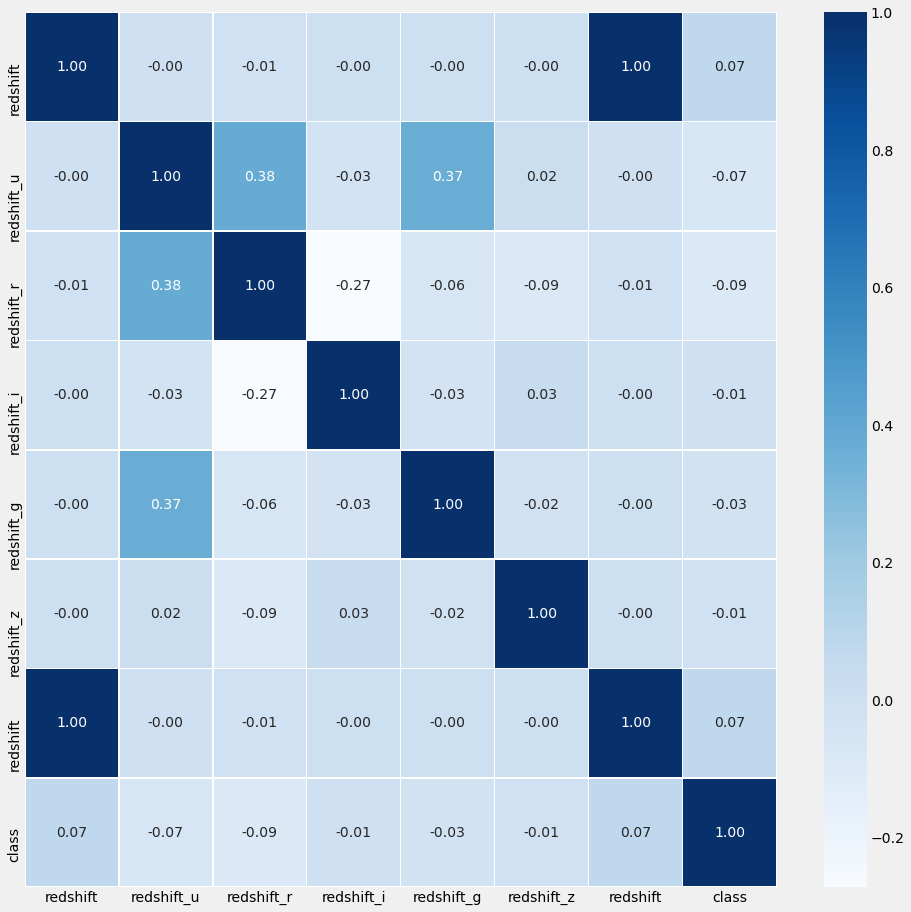

In [27]:
df_trn[cols_redshift + ['class']].corr().style.background_gradient()
plt.figure(figsize=(15,15))
# ?
sns.heatmap(data = df_trn[cols_redshift + ['redshift','class']].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [28]:
class12 = df_trn[df_trn['class'] != 0]

In [29]:
class12.corr().style.background_gradient()

In [30]:
cols_clean = ['u', 'g', 'r', 'i', 'z', 'redshift', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z','nObserve_log', 'nDetect_log']
d_cols = [ 'redshift','d_dered_u', 'd_dered_g', 'd_dered_r', 'd_dered_i', 'd_dered_z', 'd_dered_zg', 'd_dered_rz', 'd_dered_iz',]
d_cols_m = [ 'redshift','d_dered_ig','d_dered_zg','d_dered_rz','d_dered_iz']
n_cols = ['redshift','n_dered_u', 'n_dered_g', 'n_dered_r', 'n_dered_i', 'n_dered_z']
n_cols_m = ['redshift','n_dered_rg','n_dered_ig','n_dered_zg','n_dered_ri','n_dered_rz','n_dered_iz']
p_cols = ['redshift','p_dered_u', 'p_dered_g', 'p_dered_r', 'p_dered_i', 'p_dered_z'] 
p_cols_m = ['redshift', 'p_dered_rg', 'p_dered_ru', 'p_dered_ig', 'p_dered_zg', 'p_dered_ri', 'p_dered_rz', 'p_dered_iz']
cols_redshift = ['redshift','redshift_u', 'redshift_r', 'redshift_i', 'redshift_g', 'redshift_z']
#cols_to_use
#cols_to_use_best
cols_to_use_fin = [
    'redshift', 
    'dered_u',
    'dered_r',
    'dered_g', 
    'dered_i', 
    'dered_z',
 'd_dered_u',
  'd_dered_r',
  'd_dered_i',
  'd_dered_z',
  'd_dered_zg',
    'd_dered_uz',
  'd_dered_rz',
  'd_dered_iz',
 'd_dered_ig',
 'n_dered_rg','n_dered_ri', 'n_dered_iz', 'n_dered_rz',
'n_dered_zg',
'n_dered_ri',
'n_dered_uz',
]


In [31]:
#Normal
#X = df_trn[cols_to_use]
#X2 = df_trn[cols_to_use_best]
#X_f = df_trn[cols_to_use_fin]

#X_d = df_trn[d_cols]
#X_dm = df_trn[d_cols_m]
#X_n = df_trn[n_cols]
#X_nm = df_trn[n_cols_m]
#X_p = df_trn[p_cols]
#X_pm = df_trn[p_cols_m]
#X_r = df_trn[cols_redshift]
#y = df_trn[target_col]

In [32]:
#X_trn2, X_val2, y_trn, y_val = train_test_split(X2, y, test_size=.2, random_state=seed)
#X_trnf, X_valf, y_trn, y_val = train_test_split(X_f, y, test_size=.2, random_state=seed)
#X_trnd, X_vald, y_trn, y_val = train_test_split(X_d, y, test_size=.2, random_state=seed)
#X_trndm, X_valdm, y_trn, y_val = train_test_split(X_dm, y, test_size=.2, random_state=seed)
#X_trnn, X_valn, y_trn, y_val = train_test_split(X_n, y, test_size=.2, random_state=seed)
#X_trnnm, X_valnm, y_trn, y_val = train_test_split(X_nm, y, test_size=.2, random_state=seed)
#X_trnp, X_valp, y_trn, y_val = train_test_split(X_p, y, test_size=.2, random_state=seed)
#X_trnr, X_valr, y_trn, y_val = train_test_split(X_r, y, test_size=.2, random_state=seed)


<h1> Logistic Regression </h1>

<h4>Polynomial Feature</h4>

In [33]:
df.head()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det,n_dered_u,n_dered_g,n_dered_r,n_dered_i,n_dered_z,n_dered_rg,n_dered_ig,n_dered_zg,n_dered_ri,n_dered_uz,n_dered_rz,n_dered_iz,p_dered_u,p_dered_g,p_dered_r,p_dered_i,p_dered_z,nObserve_log,nDetect_log,redshift_u,redshift_r,redshift_i,redshift_g,redshift_z
0,0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1100e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-0.0402,-0.0305,-0.0543,-0.0403,324,0.9940,0.9961,0.9971,0.9977,0.9982,0.9357,0.8704,1.1981,1.0750,1.3676,1.1210,1.0428,-0.1389,-0.0787,-0.0542,-0.0402,-0.0306,2.9444,2.9444,0.0060,0.0029,0.0023,0.0039,0.0018
1,1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.0321,-0.0341,-0.0409,-0.0321,1,0.9943,0.9959,0.9970,0.9976,0.9974,0.9576,0.9451,1.0662,1.0132,1.1395,1.0211,1.0077,-0.0852,-0.0572,-0.0409,-0.0321,-0.0342,0.6931,0.6931,0.0057,0.0031,0.0024,0.0041,0.0026
2,2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.0712,-0.0535,-0.0959,-0.0716,4,0.9894,0.9912,0.9938,0.9953,0.9965,0.9843,0.9767,1.0255,1.0077,1.0857,1.0094,1.0017,-0.1768,-0.1376,-0.0957,-0.0715,-0.0538,1.0986,1.0986,0.0108,0.0062,0.0047,0.0089,0.0035
3,3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8100e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-0.0994,-0.0787,-0.1333,-0.0999,12,0.9880,0.9908,0.9934,0.9950,0.9960,0.9568,0.9428,1.0736,1.0148,1.2965,1.0272,1.0122,-0.3033,-0.1923,-0.1330,-0.0998,-0.0791,1.6094,1.3863,0.0121,0.0067,0.0051,0.0092,0.0041
4,4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3200e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-0.1322,-0.1054,-0.1783,-0.1331,156,0.9721,0.9872,0.9906,0.9927,0.9941,0.9231,0.8902,1.1431,1.0370,1.3298,1.0552,1.0176,-0.6630,-0.2619,-0.1777,-0.1329,-0.1061,2.6391,2.5649,0.0287,0.0095,0.0074,0.0130,0.0060


In [39]:
scaler = StandardScaler()
poly = PolynomialFeatures(2)
df.drop('id',axis=1)
X = poly.fit_transform(scaler.fit_transform(df.drop(target_col, axis=1)))
feature_names = poly.get_feature_names(df.columns)
feature_names

['1',
 'id',
 'u',
 'g',
 'r',
 'i',
 'z',
 'redshift',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'nObserve',
 'nDetect',
 'airmass_u',
 'class',
 'd_dered_u',
 'd_dered_g',
 'd_dered_r',
 'd_dered_i',
 'd_dered_z',
 'd_dered_ig',
 'd_dered_zg',
 'd_dered_rz',
 'd_dered_iz',
 'd_obs_det',
 'n_dered_u',
 'n_dered_g',
 'n_dered_r',
 'n_dered_i',
 'n_dered_z',
 'n_dered_rg',
 'n_dered_ig',
 'n_dered_zg',
 'n_dered_ri',
 'n_dered_uz',
 'n_dered_rz',
 'n_dered_iz',
 'p_dered_u',
 'p_dered_g',
 'p_dered_r',
 'p_dered_i',
 'p_dered_z',
 'nObserve_log',
 'nDetect_log',
 'redshift_u',
 'redshift_r',
 'redshift_i',
 'redshift_g',
 'id^2',
 'id u',
 'id g',
 'id r',
 'id i',
 'id z',
 'id redshift',
 'id dered_u',
 'id dered_g',
 'id dered_r',
 'id dered_i',
 'id dered_z',
 'id nObserve',
 'id nDetect',
 'id airmass_u',
 'id class',
 'id d_dered_u',
 'id d_dered_g',
 'id d_dered_r',
 'id d_dered_i',
 'id d_dered_z',
 'id d_dered_ig',
 'id d_dered_zg',
 'id d_dered_rz',
 'id d_d

In [41]:
df_poly = pd.DataFrame(data=X, columns=feature_names, index=df.index)
df_poly[target_col] = df[target_col]
df_poly.head()
df_poly.to_csv('feature_poly.csv', index= False, encoding = 'utf-8-sig')

KeyboardInterrupt: 

lr -> 시간이 없어 패스했음

<h3> Stratified KFold Cross Validation</h3>

In [ ]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

<h3>Logistic Regression 모델 학습</h3>

In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = LogisticRegression(multi_class='multinomial')
    clf.fit(trn[i_trn], y[i_trn])
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

In [ ]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

In [ ]:
print(p_val.shape, p_tst.shape)

In [ ]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<h3>피처 중요도 시각화</h3>

<h3>Stacking Feature 생성<h3>

In [44]:
model_names = ['lgbm1_feature','lgbm2_feature','lgbm3_feature','lgbm4_feature','xgbcv_best_feature','rf1_feature','rf2_feature']
trn = []
tst = []
feature_names = []
for model in model_names:
    trn.append(np.loadtxt(val_dir / f'{model}.val.csv', delimiter=','))
    tst.append(np.loadtxt(tst_dir / f'{model}.tst.csv', delimiter=','))
    feature_names += [f'{model}_class0', f'{model}_class1', f'{model}_class2']
    
trn = np.hstack(trn)
tst = np.hstack(tst)
feature_names

['lgbm1_feature_class0',
 'lgbm1_feature_class1',
 'lgbm1_feature_class2',
 'lgbm2_feature_class0',
 'lgbm2_feature_class1',
 'lgbm2_feature_class2',
 'lgbm3_feature_class0',
 'lgbm3_feature_class1',
 'lgbm3_feature_class2',
 'lgbm4_feature_class0',
 'lgbm4_feature_class1',
 'lgbm4_feature_class2',
 'xgbcv_best_feature_class0',
 'xgbcv_best_feature_class1',
 'xgbcv_best_feature_class2',
 'rf1_feature_class0',
 'rf1_feature_class1',
 'rf1_feature_class2',
 'rf2_feature_class0',
 'rf2_feature_class1',
 'rf2_feature_class2']

In [45]:
y = pd.read_csv(trn_file, index_col=0, usecols=['id', target_col]).values.flatten()
y.shape

(320000,)

In [47]:
n_fold = 5
n_class =3
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)


<h2> LGBM 모델학습 </h2>

In [55]:
trn

array([[9.99990e-01, 3.00000e-06, 7.00000e-06, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.57697e-01, 3.90876e-01, 4.51427e-01, ..., 7.87470e-02,
        2.88474e-01, 6.32778e-01],
       [9.99479e-01, 3.94000e-04, 1.27000e-04, ..., 9.87418e-01,
        5.76900e-03, 6.81300e-03],
       ...,
       [9.99974e-01, 9.00000e-06, 1.70000e-05, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [9.99974e-01, 1.30000e-05, 1.40000e-05, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [9.99828e-01, 7.50000e-05, 9.80000e-05, ..., 9.92000e-01,
        5.00000e-03, 3.00000e-03]])

In [70]:
params = {
    "objective": "multiclass",
    "n_estimators": 1500,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "num_leaves": hp.choice("num_leaves", [10,16,24,32,64]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, 1.0, 0.1),
    "subsample": hp.quniform("subsample", .8, 1.0, 0.05),
    "min_child_samples": hp.choice('min_child_samples', np.linspace(10, 200, 5, dtype=int)),
    
}

In [71]:
def objective(hyperparams):
    for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
        print(f'training model for CV #{i}')
        model = lgb.LGBMClassifier(**params, **hyperparams)
        model.fit(trn[i_trn], y[i_trn],
                  eval_set=[(trn[i_val], y[i_val])],
              eval_metric="multi_logloss",
              early_stopping_rounds=30,
              verbose=False)
        score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

training model for CV #1                              
training model for CV #2                              
training model for CV #3                              
training model for CV #4                              
training model for CV #5                              
training model for CV #1                                                         
training model for CV #2                                                         
training model for CV #3                                                         
training model for CV #4                                                         
training model for CV #5                                                         
training model for CV #1                                                         
training model for CV #2                                                         
training model for CV #3                                                         
training model for CV #4                                             

In [72]:
import lightgbm as lgb
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=30)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.929852
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 0.879385
[3]	valid_0's multi_logloss: 0.833522
[4]	valid_0's multi_logloss: 0.791649
[5]	valid_0's multi_logloss: 0.753183
[6]	valid_0's multi_logloss: 0.717756
[7]	valid_0's multi_logloss: 0.684977
[8]	valid_0's multi_logloss: 0.654581
[9]	valid_0's multi_logloss: 0.626339
[10]	valid_0's multi_logloss: 0.600016
[11]	valid_0's multi_logloss: 0.575482
[12]	valid_0's multi_logloss: 0.552546
[13]	valid_0's multi_logloss: 0.531083
[14]	valid_0's multi_logloss: 0.510971
[15]	valid_0's multi_logloss: 0.492101
[16]	valid_0's multi_logloss: 0.474385
[17]	valid_0's multi_logloss: 0.457766
[18]	valid_0's multi_logloss: 0.442082
[19]	valid_0's multi_logloss: 0.427317
[20]	valid_0's multi_logloss: 0.413392
[21]	valid_0's multi_logloss: 0.400274
[22]	valid_0's multi_logloss: 0.38789
[23]	valid_0's multi_logloss: 0.376202
[24]	valid_0's multi_loglos

[214]	valid_0's multi_logloss: 0.151107
[215]	valid_0's multi_logloss: 0.1511
[216]	valid_0's multi_logloss: 0.151089
[217]	valid_0's multi_logloss: 0.151081
[218]	valid_0's multi_logloss: 0.151072
[219]	valid_0's multi_logloss: 0.151065
[220]	valid_0's multi_logloss: 0.151062
[221]	valid_0's multi_logloss: 0.15105
[222]	valid_0's multi_logloss: 0.151046
[223]	valid_0's multi_logloss: 0.151038
[224]	valid_0's multi_logloss: 0.151032
[225]	valid_0's multi_logloss: 0.151024
[226]	valid_0's multi_logloss: 0.151016
[227]	valid_0's multi_logloss: 0.151009
[228]	valid_0's multi_logloss: 0.151009
[229]	valid_0's multi_logloss: 0.151002
[230]	valid_0's multi_logloss: 0.150994
[231]	valid_0's multi_logloss: 0.15099
[232]	valid_0's multi_logloss: 0.150981
[233]	valid_0's multi_logloss: 0.150983
[234]	valid_0's multi_logloss: 0.150979
[235]	valid_0's multi_logloss: 0.150977
[236]	valid_0's multi_logloss: 0.150974
[237]	valid_0's multi_logloss: 0.150971
[238]	valid_0's multi_logloss: 0.150965
[239

[55]	valid_0's multi_logloss: 0.203815
[56]	valid_0's multi_logloss: 0.201674
[57]	valid_0's multi_logloss: 0.199644
[58]	valid_0's multi_logloss: 0.197707
[59]	valid_0's multi_logloss: 0.195858
[60]	valid_0's multi_logloss: 0.194084
[61]	valid_0's multi_logloss: 0.192399
[62]	valid_0's multi_logloss: 0.190786
[63]	valid_0's multi_logloss: 0.189245
[64]	valid_0's multi_logloss: 0.187776
[65]	valid_0's multi_logloss: 0.186376
[66]	valid_0's multi_logloss: 0.185036
[67]	valid_0's multi_logloss: 0.183747
[68]	valid_0's multi_logloss: 0.18252
[69]	valid_0's multi_logloss: 0.181345
[70]	valid_0's multi_logloss: 0.180221
[71]	valid_0's multi_logloss: 0.179148
[72]	valid_0's multi_logloss: 0.178126
[73]	valid_0's multi_logloss: 0.177146
[74]	valid_0's multi_logloss: 0.176204
[75]	valid_0's multi_logloss: 0.175308
[76]	valid_0's multi_logloss: 0.174447
[77]	valid_0's multi_logloss: 0.173622
[78]	valid_0's multi_logloss: 0.172834
[79]	valid_0's multi_logloss: 0.172082
[80]	valid_0's multi_loglo

[264]	valid_0's multi_logloss: 0.152128
[265]	valid_0's multi_logloss: 0.15213
[266]	valid_0's multi_logloss: 0.152124
[267]	valid_0's multi_logloss: 0.152122
[268]	valid_0's multi_logloss: 0.152118
[269]	valid_0's multi_logloss: 0.152114
[270]	valid_0's multi_logloss: 0.152111
[271]	valid_0's multi_logloss: 0.152108
[272]	valid_0's multi_logloss: 0.152104
[273]	valid_0's multi_logloss: 0.152104
[274]	valid_0's multi_logloss: 0.152102
[275]	valid_0's multi_logloss: 0.152093
[276]	valid_0's multi_logloss: 0.152092
[277]	valid_0's multi_logloss: 0.152088
[278]	valid_0's multi_logloss: 0.152079
[279]	valid_0's multi_logloss: 0.15207
[280]	valid_0's multi_logloss: 0.152067
[281]	valid_0's multi_logloss: 0.152065
[282]	valid_0's multi_logloss: 0.152059
[283]	valid_0's multi_logloss: 0.152059
[284]	valid_0's multi_logloss: 0.152059
[285]	valid_0's multi_logloss: 0.152057
[286]	valid_0's multi_logloss: 0.152054
[287]	valid_0's multi_logloss: 0.152046
[288]	valid_0's multi_logloss: 0.152041
[2

[72]	valid_0's multi_logloss: 0.179211
[73]	valid_0's multi_logloss: 0.178235
[74]	valid_0's multi_logloss: 0.177302
[75]	valid_0's multi_logloss: 0.176411
[76]	valid_0's multi_logloss: 0.175556
[77]	valid_0's multi_logloss: 0.174733
[78]	valid_0's multi_logloss: 0.173952
[79]	valid_0's multi_logloss: 0.173202
[80]	valid_0's multi_logloss: 0.172485
[81]	valid_0's multi_logloss: 0.171792
[82]	valid_0's multi_logloss: 0.171134
[83]	valid_0's multi_logloss: 0.1705
[84]	valid_0's multi_logloss: 0.169895
[85]	valid_0's multi_logloss: 0.169314
[86]	valid_0's multi_logloss: 0.168755
[87]	valid_0's multi_logloss: 0.168223
[88]	valid_0's multi_logloss: 0.167711
[89]	valid_0's multi_logloss: 0.167219
[90]	valid_0's multi_logloss: 0.166741
[91]	valid_0's multi_logloss: 0.166291
[92]	valid_0's multi_logloss: 0.165862
[93]	valid_0's multi_logloss: 0.165441
[94]	valid_0's multi_logloss: 0.165035
[95]	valid_0's multi_logloss: 0.164645
[96]	valid_0's multi_logloss: 0.164268
[97]	valid_0's multi_loglos

[284]	valid_0's multi_logloss: 0.153542
[285]	valid_0's multi_logloss: 0.153546
[286]	valid_0's multi_logloss: 0.153545
[287]	valid_0's multi_logloss: 0.153546
[288]	valid_0's multi_logloss: 0.153546
[289]	valid_0's multi_logloss: 0.153549
[290]	valid_0's multi_logloss: 0.153543
[291]	valid_0's multi_logloss: 0.153541
[292]	valid_0's multi_logloss: 0.153539
[293]	valid_0's multi_logloss: 0.153541
[294]	valid_0's multi_logloss: 0.153542
[295]	valid_0's multi_logloss: 0.153535
[296]	valid_0's multi_logloss: 0.153535
[297]	valid_0's multi_logloss: 0.15353
[298]	valid_0's multi_logloss: 0.153523
[299]	valid_0's multi_logloss: 0.15352
[300]	valid_0's multi_logloss: 0.153516
[301]	valid_0's multi_logloss: 0.153515
[302]	valid_0's multi_logloss: 0.153513
[303]	valid_0's multi_logloss: 0.153515
[304]	valid_0's multi_logloss: 0.153518
[305]	valid_0's multi_logloss: 0.15352
[306]	valid_0's multi_logloss: 0.153528
[307]	valid_0's multi_logloss: 0.153526
[308]	valid_0's multi_logloss: 0.153527
[30

[114]	valid_0's multi_logloss: 0.158114
[115]	valid_0's multi_logloss: 0.157932
[116]	valid_0's multi_logloss: 0.157757
[117]	valid_0's multi_logloss: 0.157589
[118]	valid_0's multi_logloss: 0.157423
[119]	valid_0's multi_logloss: 0.157262
[120]	valid_0's multi_logloss: 0.157113
[121]	valid_0's multi_logloss: 0.156962
[122]	valid_0's multi_logloss: 0.156821
[123]	valid_0's multi_logloss: 0.15668
[124]	valid_0's multi_logloss: 0.156545
[125]	valid_0's multi_logloss: 0.156418
[126]	valid_0's multi_logloss: 0.156293
[127]	valid_0's multi_logloss: 0.156166
[128]	valid_0's multi_logloss: 0.156049
[129]	valid_0's multi_logloss: 0.155939
[130]	valid_0's multi_logloss: 0.155828
[131]	valid_0's multi_logloss: 0.155726
[132]	valid_0's multi_logloss: 0.155623
[133]	valid_0's multi_logloss: 0.15552
[134]	valid_0's multi_logloss: 0.155425
[135]	valid_0's multi_logloss: 0.155333
[136]	valid_0's multi_logloss: 0.155247
[137]	valid_0's multi_logloss: 0.155162
[138]	valid_0's multi_logloss: 0.155077
[1

[321]	valid_0's multi_logloss: 0.152292
[322]	valid_0's multi_logloss: 0.152292
[323]	valid_0's multi_logloss: 0.152296
[324]	valid_0's multi_logloss: 0.152296
[325]	valid_0's multi_logloss: 0.152291
[326]	valid_0's multi_logloss: 0.152288
[327]	valid_0's multi_logloss: 0.152288
[328]	valid_0's multi_logloss: 0.152292
[329]	valid_0's multi_logloss: 0.15229
[330]	valid_0's multi_logloss: 0.152292
[331]	valid_0's multi_logloss: 0.152295
[332]	valid_0's multi_logloss: 0.152296
[333]	valid_0's multi_logloss: 0.152296
[334]	valid_0's multi_logloss: 0.152294
[335]	valid_0's multi_logloss: 0.152296
[336]	valid_0's multi_logloss: 0.152299
[337]	valid_0's multi_logloss: 0.152293
[338]	valid_0's multi_logloss: 0.152292
[339]	valid_0's multi_logloss: 0.152296
[340]	valid_0's multi_logloss: 0.152296
[341]	valid_0's multi_logloss: 0.152297
[342]	valid_0's multi_logloss: 0.152297
[343]	valid_0's multi_logloss: 0.152299
[344]	valid_0's multi_logloss: 0.152294
[345]	valid_0's multi_logloss: 0.152292
E

[188]	valid_0's multi_logloss: 0.150936
[189]	valid_0's multi_logloss: 0.150913
[190]	valid_0's multi_logloss: 0.150895
[191]	valid_0's multi_logloss: 0.150877
[192]	valid_0's multi_logloss: 0.150863
[193]	valid_0's multi_logloss: 0.150846
[194]	valid_0's multi_logloss: 0.150832
[195]	valid_0's multi_logloss: 0.150818
[196]	valid_0's multi_logloss: 0.1508
[197]	valid_0's multi_logloss: 0.150784
[198]	valid_0's multi_logloss: 0.15077
[199]	valid_0's multi_logloss: 0.150751
[200]	valid_0's multi_logloss: 0.150739
[201]	valid_0's multi_logloss: 0.150725
[202]	valid_0's multi_logloss: 0.150715
[203]	valid_0's multi_logloss: 0.150702
[204]	valid_0's multi_logloss: 0.150686
[205]	valid_0's multi_logloss: 0.150673
[206]	valid_0's multi_logloss: 0.150661
[207]	valid_0's multi_logloss: 0.150646
[208]	valid_0's multi_logloss: 0.150634
[209]	valid_0's multi_logloss: 0.150626
[210]	valid_0's multi_logloss: 0.150616
[211]	valid_0's multi_logloss: 0.150603
[212]	valid_0's multi_logloss: 0.150593
[21

In [73]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.6416%


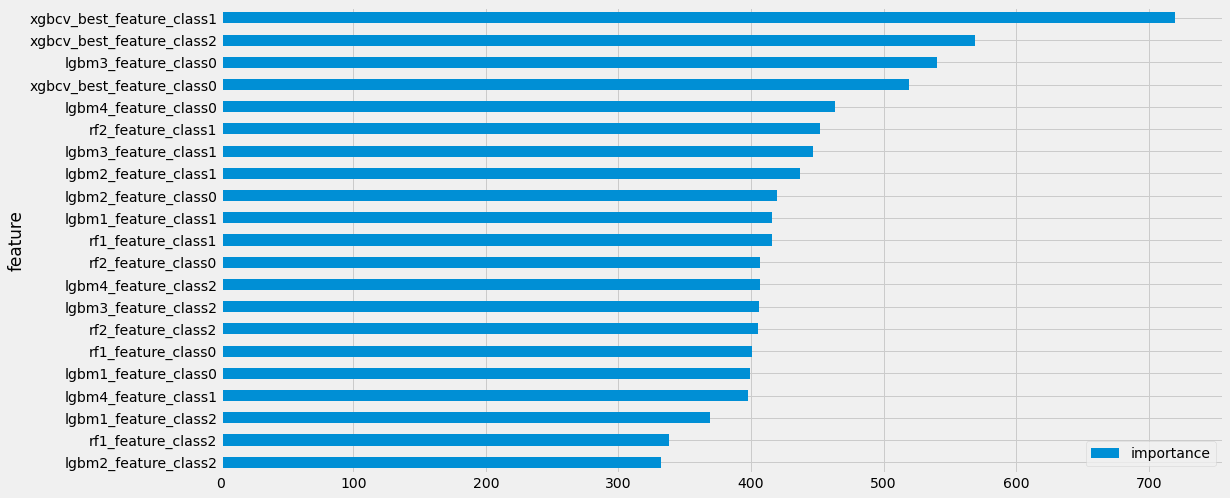

In [74]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

Submission 생성 및 제출

In [75]:
sub = submission
sub.head()

,id,class
0,320000,0
1,320001,0
2,320002,0
3,320003,0
4,320004,0


In [76]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,id,class
0,320000,2
1,320001,0
2,320002,2
3,320003,0
4,320004,2


In [77]:
sub[target_col].value_counts()

2    40706
0    29998
1     9296
Name: class, dtype: int64

In [78]:
sub.to_csv('LGBM_Stacking_withhyperopt_93,64.csv', index = False , encoding = 'utf-8-sig')

In [49]:
import lightgbm as lgb

p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=0.1,
                             min_child_samples=10,
                             subsample=.5,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.833214
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.719657
[3]	valid_0's multi_logloss: 0.630439
[4]	valid_0's multi_logloss: 0.558297
[5]	valid_0's multi_logloss: 0.499016
[6]	valid_0's multi_logloss: 0.449838
[7]	valid_0's multi_logloss: 0.408535
[8]	valid_0's multi_logloss: 0.373692
[9]	valid_0's multi_logloss: 0.344071
[10]	valid_0's multi_logloss: 0.318833
[11]	valid_0's multi_logloss: 0.297229
[12]	valid_0's multi_logloss: 0.27865
[13]	valid_0's multi_logloss: 0.262686
[14]	valid_0's multi_logloss: 0.248895
[15]	valid_0's multi_logloss: 0.236995
[16]	valid_0's multi_logloss: 0.226654
[17]	valid_0's multi_logloss: 0.217726
[18]	valid_0's multi_logloss: 0.209901
[19]	valid_0's multi_logloss: 0.203075
[20]	valid_0's multi_logloss: 0.197093
[21]	valid_0's multi_logloss: 0.191946
[22]	valid_0's multi_logloss: 0.187397
[23]	valid_0's multi_logloss: 0.183443
[24]	valid_0's multi_loglos

[7]	valid_0's multi_logloss: 0.410003
[8]	valid_0's multi_logloss: 0.375204
[9]	valid_0's multi_logloss: 0.345582
[10]	valid_0's multi_logloss: 0.320369
[11]	valid_0's multi_logloss: 0.298759
[12]	valid_0's multi_logloss: 0.280233
[13]	valid_0's multi_logloss: 0.264314
[14]	valid_0's multi_logloss: 0.250565
[15]	valid_0's multi_logloss: 0.238675
[16]	valid_0's multi_logloss: 0.228421
[17]	valid_0's multi_logloss: 0.219434
[18]	valid_0's multi_logloss: 0.211604
[19]	valid_0's multi_logloss: 0.20481
[20]	valid_0's multi_logloss: 0.198893
[21]	valid_0's multi_logloss: 0.193628
[22]	valid_0's multi_logloss: 0.189116
[23]	valid_0's multi_logloss: 0.185074
[24]	valid_0's multi_logloss: 0.18154
[25]	valid_0's multi_logloss: 0.178454
[26]	valid_0's multi_logloss: 0.175707
[27]	valid_0's multi_logloss: 0.173272
[28]	valid_0's multi_logloss: 0.171155
[29]	valid_0's multi_logloss: 0.16934
[30]	valid_0's multi_logloss: 0.167708
[31]	valid_0's multi_logloss: 0.166205
[32]	valid_0's multi_logloss: 0

In [68]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.6178%


In [52]:
print(p_val.shape, p_tst.shape)


(320000, 3) (80000, 3)


In [ ]:
#
# lgbm Stacking -> 93.64% 
# cv Xgboost -> 93.628 % 
#   XGB보다Stacking가 성능이 더 좋은 느낌
#